In [2]:
import os
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [4]:
pip install --upgrade torchvision

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 50.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779.2 MB 17.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 30.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 19.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: triton
    Found existing installation: triton 2.2.0
    Uninstalling triton-2.2.0:
      Successfully uninstalled triton-2.2.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.19.3
    Uninstalling nvidia-nccl-cu12-2.19.3:
      Successfully uninstalled nvidia-nccl-cu12-2.19.3
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1
    Uninstalling torch-2.2.1:
      Successfully uninstalled torch-2.2.1
  Rolling back uninstall of torch
  Moving to /home/ps4896/.local/b

In [3]:
SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 64
NUM_CLASSES = 15
CLASS_LABELS = ['Abuse','Arrest','Arson','Assault','Burglary','Explosion','Fighting','Normals', 'Protest', 'RoadAccidents','Robbery','Shooting','Shoplifting','Stealing','Vandalism']
DATA_DIR = '/scratch/ps4896/UCF_Crime/Test'
LR = 0.0001
NUM_EPOCHS = 1

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
train_dataset = datasets.ImageFolder(root=DATA_DIR, transform=train_transform)
test_dataset = datasets.ImageFolder(root=DATA_DIR, transform=test_transform)

# Split dataset into train and test
train_size = int(0.8 * len(train_dataset))
test_size = len(train_dataset) - train_size
train_dataset, test_dataset = random_split(train_dataset, [train_size, test_size])

In [6]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        # Pre-trained DenseNet121 without the final fully connected layers
        self.densenet = models.densenet121(pretrained=True)
        self.densenet = nn.Sequential(*list(self.densenet.children())[:-1])  # Remove last layer

    def forward(self, x):
        # Use the pre-trained DenseNet121 model
        return self.densenet(x)

class Classifier(nn.Module):
    def __init__(self, num_classes):
        super(Classifier, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

class FinalModel(nn.Module):
    def __init__(self, num_classes):
        super(FinalModel, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.classifier = Classifier(num_classes)

    def forward(self, x):
        features = self.feature_extractor(x)
        output = self.classifier(features)
        return output

# Define and compile the model
model = FinalModel(NUM_CLASSES)

# Print model summary
print(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

/home/ps4896/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ps4896/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FinalModel(
  (feature_extractor): FeatureExtractor(
    (densenet): Sequential(
      (0): Sequential(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace=True)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (denselayer2):

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training loop
history = {'loss': [], 'val_loss': []}
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * inputs.size(0)
    epoch_loss /= len(train_loader.dataset)
    history['loss'].append(epoch_loss)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {epoch_loss:.4f}")

# Evaluation
model.eval()
preds = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds.extend(outputs.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate ROC AUC score
y_test = np.array(true_labels)
y_pred = np.array(preds)
roc_auc = roc_auc_score(y_test, y_pred, average='macro')

# Plot ROC curve
fig, c_ax = plt.subplots(1, 1, figsize=(15, 8))
for idx, c_label in enumerate(CLASS_LABELS):
    fpr, tpr, _ = roc_curve(y_test[:, idx], y_pred[:, idx])
    c_ax.plot(fpr, tpr, lw=2, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
c_ax.plot([0, 1], [0, 1], 'black', linestyle='dashed', lw=4, label='Random Guessing')
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize=11.5)
plt.show()

print('ROC AUC score:', roc_auc)

Epoch [1/1], Loss: 2.5753


NameError: name 'np' is not defined

In [9]:
import numpy as np

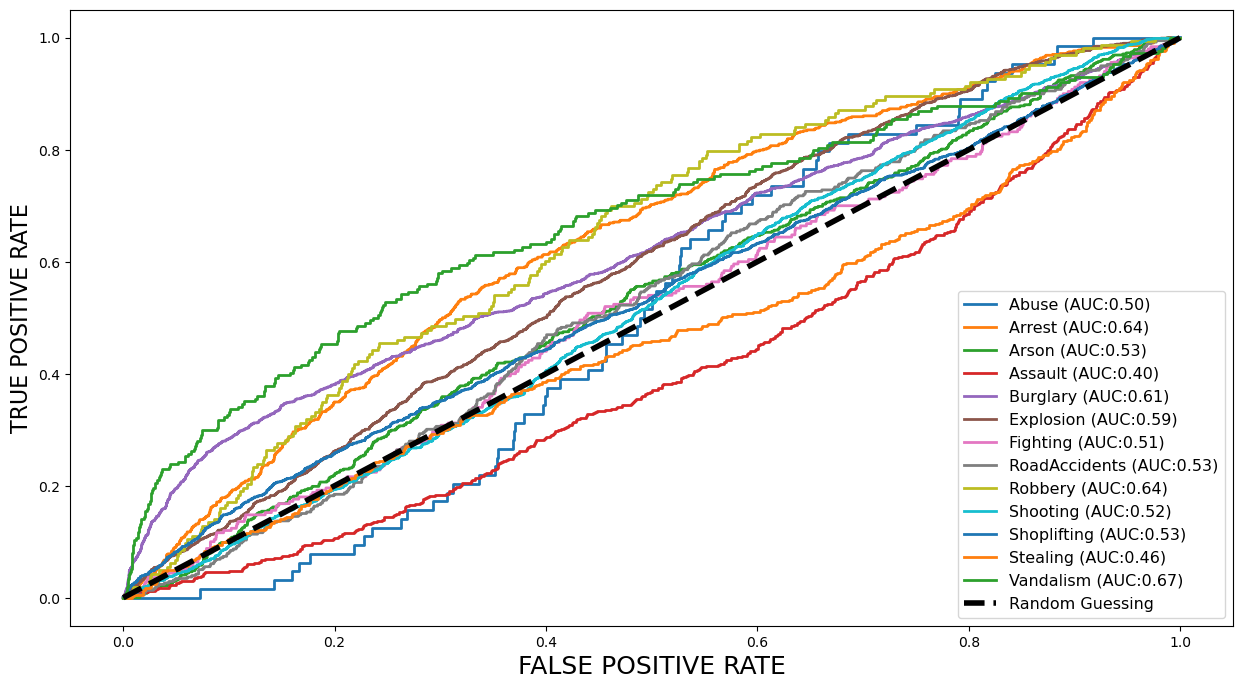

ROC AUC score: 0.5472325427319179


In [15]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Evaluation
model.eval()
preds = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds.extend(outputs.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Reshape y_pred_probs to match the expected shape for computing ROC curves
y_pred_probs = np.array(preds)

# Calculate ROC AUC score
y_test = np.array(true_labels)

# Plot ROC curve
fig, c_ax = plt.subplots(1, 1, figsize=(15, 8))
for idx, c_label in enumerate(CLASS_LABELS):
    fpr, tpr, _ = roc_curve(y_test == idx, y_pred_probs[:, idx])
    c_ax.plot(fpr, tpr, lw=2, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
c_ax.plot([0, 1], [0, 1], 'black', linestyle='dashed', lw=4, label='Random Guessing')
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize=11.5)
plt.show()

print('ROC AUC score:', roc_auc)



In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS=10

# Training loop
history = {'loss': [], 'val_loss': []}
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * inputs.size(0)
    epoch_loss /= len(train_loader.dataset)
    history['loss'].append(epoch_loss)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {epoch_loss:.4f}")


Epoch [1/10], Loss: 2.4461
Epoch [2/10], Loss: 2.4157
Epoch [3/10], Loss: 2.3868
Epoch [4/10], Loss: 2.3549
Epoch [5/10], Loss: 2.3242
Epoch [6/10], Loss: 2.2945
Epoch [7/10], Loss: 2.2635
Epoch [8/10], Loss: 2.2337
Epoch [9/10], Loss: 2.1998
Epoch [10/10], Loss: 2.1706


In [7]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Evaluation
model.eval()
preds = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds.extend(outputs.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Reshape y_pred_probs to match the expected shape for computing ROC curves
y_pred_probs = np.array(preds)

# Calculate ROC AUC score
y_test = np.array(true_labels)

# Plot ROC curve
fig, c_ax = plt.subplots(1, 1, figsize=(15, 8))
for idx, c_label in enumerate(CLASS_LABELS):
    fpr, tpr, _ = roc_curve(y_test == idx, y_pred_probs[:, idx])
    c_ax.plot(fpr, tpr, lw=2, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
c_ax.plot([0, 1], [0, 1], 'black', linestyle='dashed', lw=4, label='Random Guessing')
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize=11.5)
plt.show()

print('ROC AUC score:', roc_auc)

from sklearn.metrics import accuracy_score

# Calculate accuracy
y_pred = np.argmax(y_pred_probs, axis=1)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.bar('Accuracy', accuracy)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.show()


NameError: name 'device' is not defined

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 1
model.to(device)

# Training loop
history = {'loss': [], 'val_loss': [], 'accuracy': []}
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * inputs.size(0)
        
        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    epoch_loss /= len(train_loader.dataset)
    accuracy = 100 * correct / total
    history['loss'].append(epoch_loss)
    history['accuracy'].append(accuracy)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")


Epoch [1/1], Loss: 2.7158, Accuracy: 6.48%


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 15
model.to(device)

# Training loop
history = {'loss': [], 'val_loss': [], 'accuracy': []}
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * inputs.size(0)
        
        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    epoch_loss /= len(train_loader.dataset)
    accuracy = 100 * correct / total
    history['loss'].append(epoch_loss)
    history['accuracy'].append(accuracy)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Plot loss and accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(1, NUM_EPOCHS + 1), history['loss'], label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.title('Training Loss and Accuracy')
plt.legend()
plt.show()


Epoch [1/15], Loss: 2.6866, Accuracy: 9.61%
Epoch [2/15], Loss: 2.6600, Accuracy: 11.95%
Epoch [3/15], Loss: 2.6341, Accuracy: 13.05%
Epoch [4/15], Loss: 2.6101, Accuracy: 13.82%
Epoch [5/15], Loss: 2.5871, Accuracy: 14.43%
Epoch [6/15], Loss: 2.5644, Accuracy: 14.47%
Epoch [7/15], Loss: 2.5426, Accuracy: 15.07%
Epoch [8/15], Loss: 2.5177, Accuracy: 15.44%
Epoch [9/15], Loss: 2.4967, Accuracy: 15.86%
Epoch [10/15], Loss: 2.4727, Accuracy: 16.28%
Epoch [11/15], Loss: 2.4487, Accuracy: 16.61%
Epoch [12/15], Loss: 2.4252, Accuracy: 17.01%
Epoch [13/15], Loss: 2.3999, Accuracy: 17.52%
Epoch [14/15], Loss: 2.3753, Accuracy: 18.03%
Epoch [15/15], Loss: 2.3468, Accuracy: 18.84%


NameError: name 'plt' is not defined

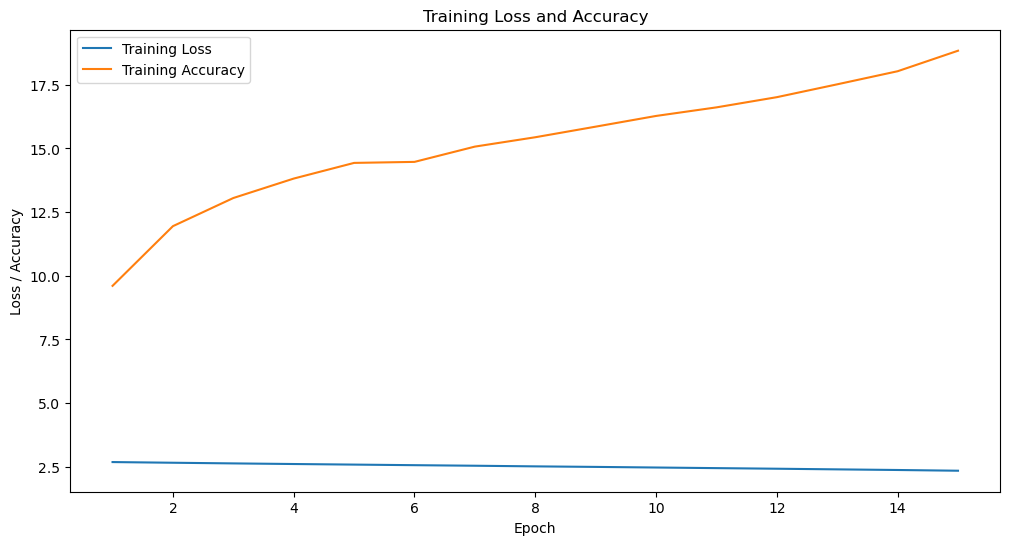

In [10]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(1, NUM_EPOCHS + 1), history['loss'], label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.title('Training Loss and Accuracy')
plt.legend()
plt.show()

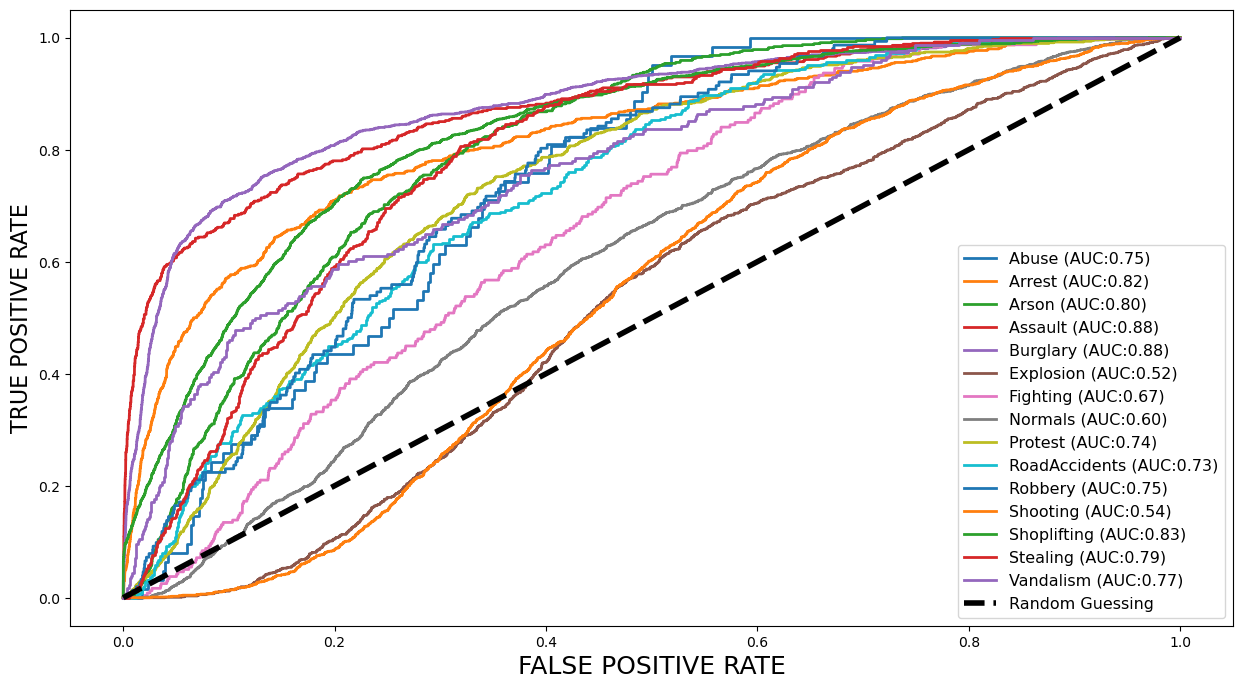

NameError: name 'roc_auc' is not defined

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Evaluation
model.eval()
preds = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds.extend(outputs.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Reshape y_pred_probs to match the expected shape for computing ROC curves
y_pred_probs = np.array(preds)

# Calculate ROC AUC score
y_test = np.array(true_labels)

# Plot ROC curve
fig, c_ax = plt.subplots(1, 1, figsize=(15, 8))
for idx, c_label in enumerate(CLASS_LABELS):
    fpr, tpr, _ = roc_curve(y_test == idx, y_pred_probs[:, idx])
    c_ax.plot(fpr, tpr, lw=2, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
c_ax.plot([0, 1], [0, 1], 'black', linestyle='dashed', lw=4, label='Random Guessing')
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize=11.5)
plt.show()

print('ROC AUC score:', roc_auc)

from sklearn.metrics import accuracy_score

# Calculate accuracy
y_pred = np.argmax(y_pred_probs, axis=1)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.bar('Accuracy', accuracy)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.show()


ROC AUC score: 0.7397821389729373


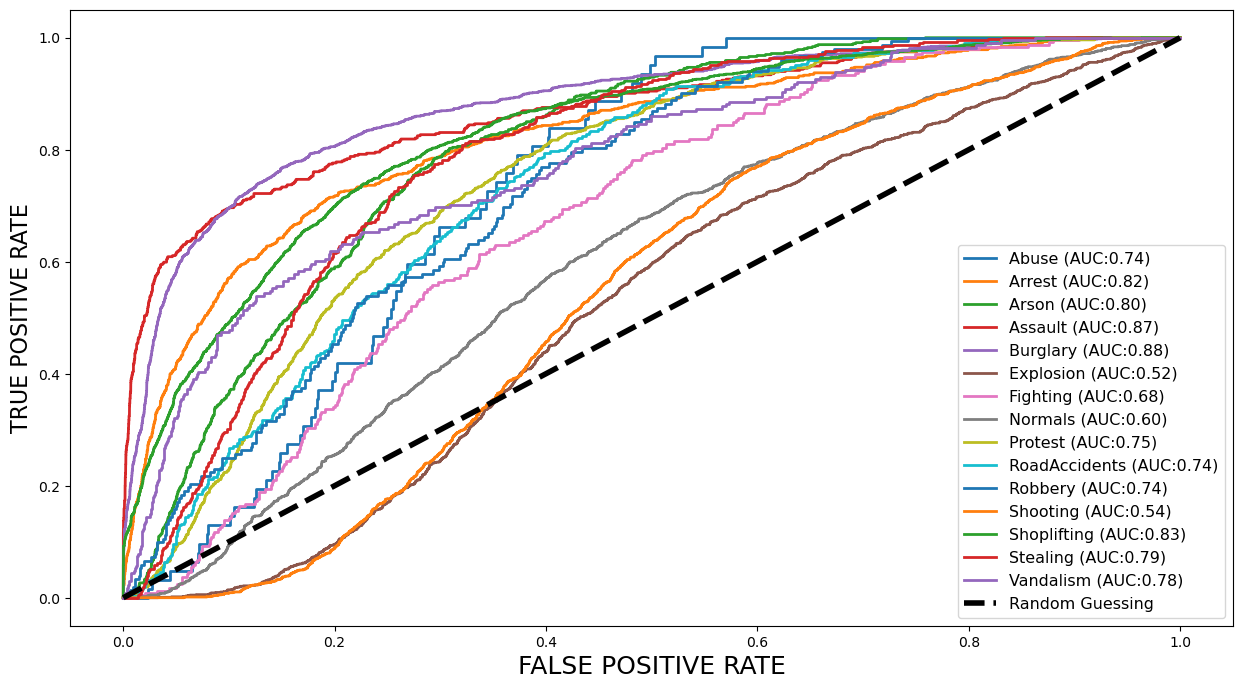

NameError: name 'accuracy_score' is not defined

In [17]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluation
model.eval()
preds = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds.extend(outputs.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Reshape y_pred_probs to match the expected shape for computing ROC curves
y_pred_probs = np.array(preds)
y_test = np.array(true_labels)

from sklearn.preprocessing import label_binarize

# Binarize the true labels
y_test_binarized = label_binarize(y_test, classes=np.arange(len(CLASS_LABELS)))

# Calculate ROC AUC score for each class
roc_auc_scores = []
for i in range(len(CLASS_LABELS)):
    roc_auc_scores.append(roc_auc_score(y_test_binarized[:, i], y_pred_probs[:, i]))

# Calculate average ROC AUC score
roc_auc = np.mean(roc_auc_scores)
print('ROC AUC score:', roc_auc)


# Plot ROC curve
fig, c_ax = plt.subplots(1, 1, figsize=(15, 8))
for idx, c_label in enumerate(CLASS_LABELS):
    fpr, tpr, _ = roc_curve(y_test == idx, y_pred_probs[:, idx])
    c_ax.plot(fpr, tpr, lw=2, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
c_ax.plot([0, 1], [0, 1], 'black', linestyle='dashed', lw=4, label='Random Guessing')
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize=11.5)
plt.show()

# Calculate accuracy
y_pred = np.argmax(y_pred_probs, axis=1)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.bar('Accuracy', accuracy)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.show()

In [18]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score


ROC AUC score: 0.7355058311573647


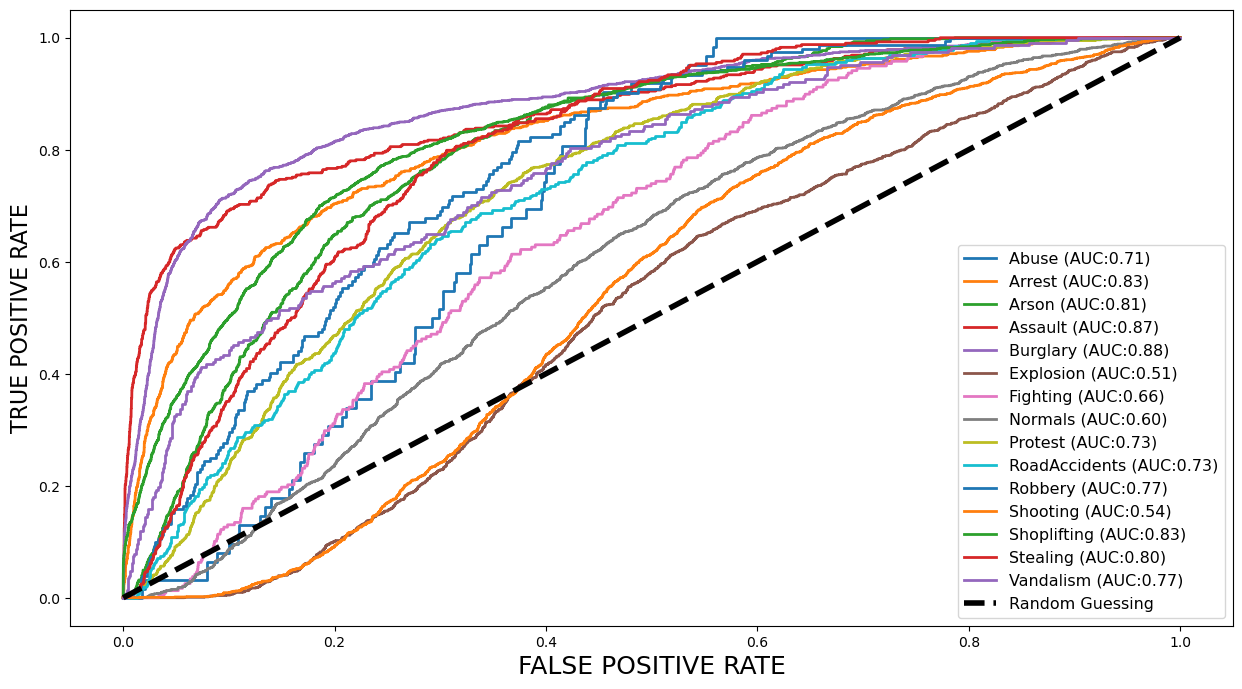

Accuracy: 0.252921388101983


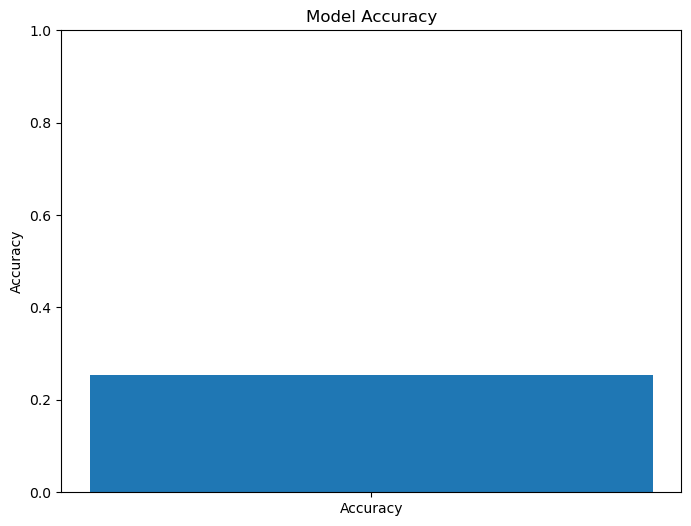

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluation
model.eval()
preds = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds.extend(outputs.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Reshape y_pred_probs to match the expected shape for computing ROC curves
y_pred_probs = np.array(preds)
y_test = np.array(true_labels)

from sklearn.preprocessing import label_binarize

# Binarize the true labels
y_test_binarized = label_binarize(y_test, classes=np.arange(len(CLASS_LABELS)))

# Calculate ROC AUC score for each class
roc_auc_scores = []
for i in range(len(CLASS_LABELS)):
    roc_auc_scores.append(roc_auc_score(y_test_binarized[:, i], y_pred_probs[:, i]))

# Calculate average ROC AUC score
roc_auc = np.mean(roc_auc_scores)
print('ROC AUC score:', roc_auc)


# Plot ROC curve
fig, c_ax = plt.subplots(1, 1, figsize=(15, 8))
for idx, c_label in enumerate(CLASS_LABELS):
    fpr, tpr, _ = roc_curve(y_test == idx, y_pred_probs[:, idx])
    c_ax.plot(fpr, tpr, lw=2, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
c_ax.plot([0, 1], [0, 1], 'black', linestyle='dashed', lw=4, label='Random Guessing')
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize=11.5)
plt.show()

# Calculate accuracy
y_pred = np.argmax(y_pred_probs, axis=1)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.bar('Accuracy', accuracy)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.show()

In [20]:
# Define the file path where you want to save the model
model_path = 'UCF_Crime.pth'

# Save the entire model
torch.save(model, model_path)

# OR save only the model state dictionary (recommended)
torch.save(model.state_dict(), model_path)

print("Model saved successfully!")


Model saved successfully!
